In this notebook I'll compare two different representation of the Iris dataset, one done by Scatter plot and the other - by ICC plot.

Link to dataset: [here](https://archive.ics.uci.edu/ml/datasets/iris).


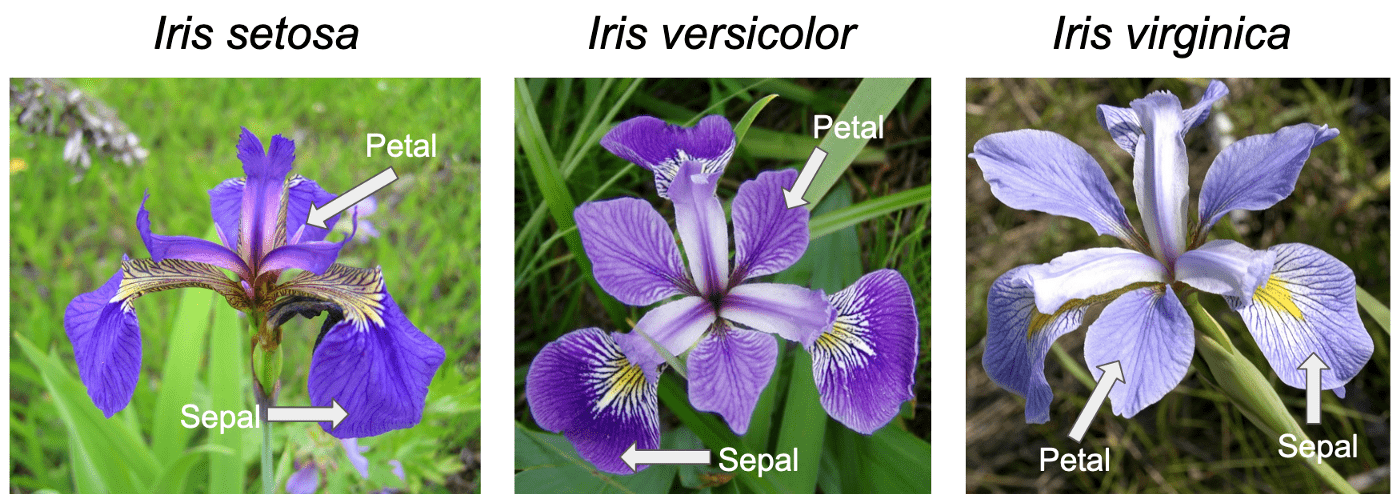

# Part 1: Loading the data

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris # Reference: https://stackoverflow.com/questions/38105539/how-to-convert-a-scikit-learn-dataset-to-a-pandas-dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['Species']).astype({'Species': 'int32'})

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Part 2: Analyzing the data using Scatter plots

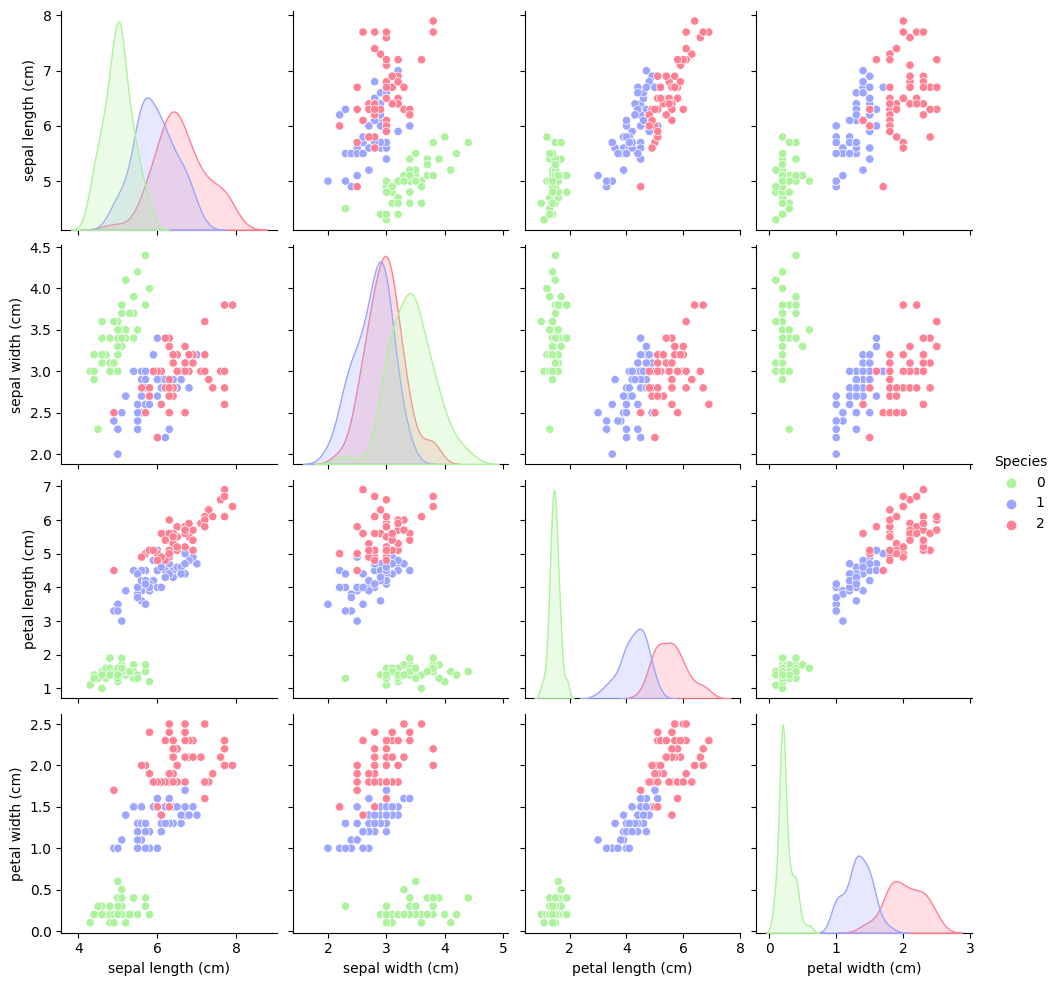

In [3]:
sns.pairplot(df, hue="Species", palette = {0: '#adf29d', 1: '#9ca5ff', 2: '#ff8093'})

From here onward I'll be using only class 1 and 2 as they are the two classes that overlap.

In [4]:
df = df[(df["Species"] == 1) | (df["Species"] == 2)]

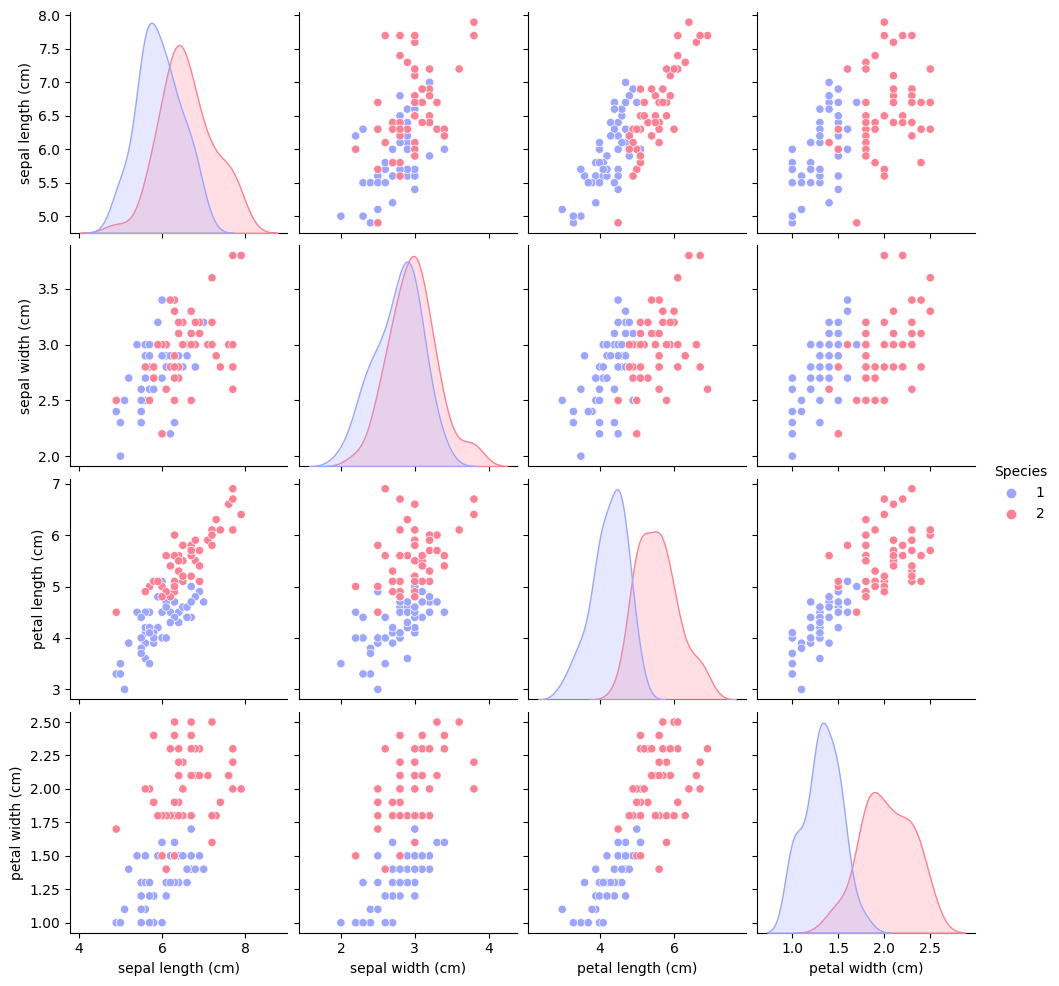

In [5]:
sns.pairplot(df, hue="Species", palette = {1: '#9ca5ff', 2: '#ff8093'})

The following code will simulate how a researcher splits the Scatter plot visually, had he or she uses only horizontal and vertical lines.

This is simulated by using a decision tree that greedily tries to split the plain into subplains.

The simulation is based on a subset of the Iris dataset, containing only the Versicolor and Virginica classes, and the Sepal width and Petal length attributes.


In [6]:
import matplotlib.colors as clr
from sklearn.tree import DecisionTreeClassifier

cmap = clr.LinearSegmentedColormap.from_list('custom cmap',
                                             [(0,    'blue'),
                                              (0.5,  'white'),
                                              (1,    'red')], N=256)

def plot_decision_boundary(X, y, classifier, ax, title, xlabel, ylabel):
  x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:,0].max() + 0.1
  y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
  x_in = np.c_[xx.ravel(), yy.ravel()]
  y_pred = classifier.predict(pd.DataFrame(x_in, columns = X.columns))
  if isinstance(y_pred, pd.Series):
    y_pred = y_pred.to_numpy()
  y_pred = np.round(y_pred).reshape(xx.shape)
  ax.contourf(xx, yy, y_pred, cmap=cmap, alpha=0.7 )
  ax.scatter(X.iloc[:,0], X.iloc[:, 1], c=y, s=40, cmap=cmap)
  ax.axis(xmin=xx.min(),xmax=xx.max())
  ax.axis(ymin=yy.min(),ymax=yy.max())
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title, fontsize=15)

In [7]:
X = df.drop(['Species', 'sepal length (cm)', 'petal width (cm)'], axis=1)
y = df['Species']

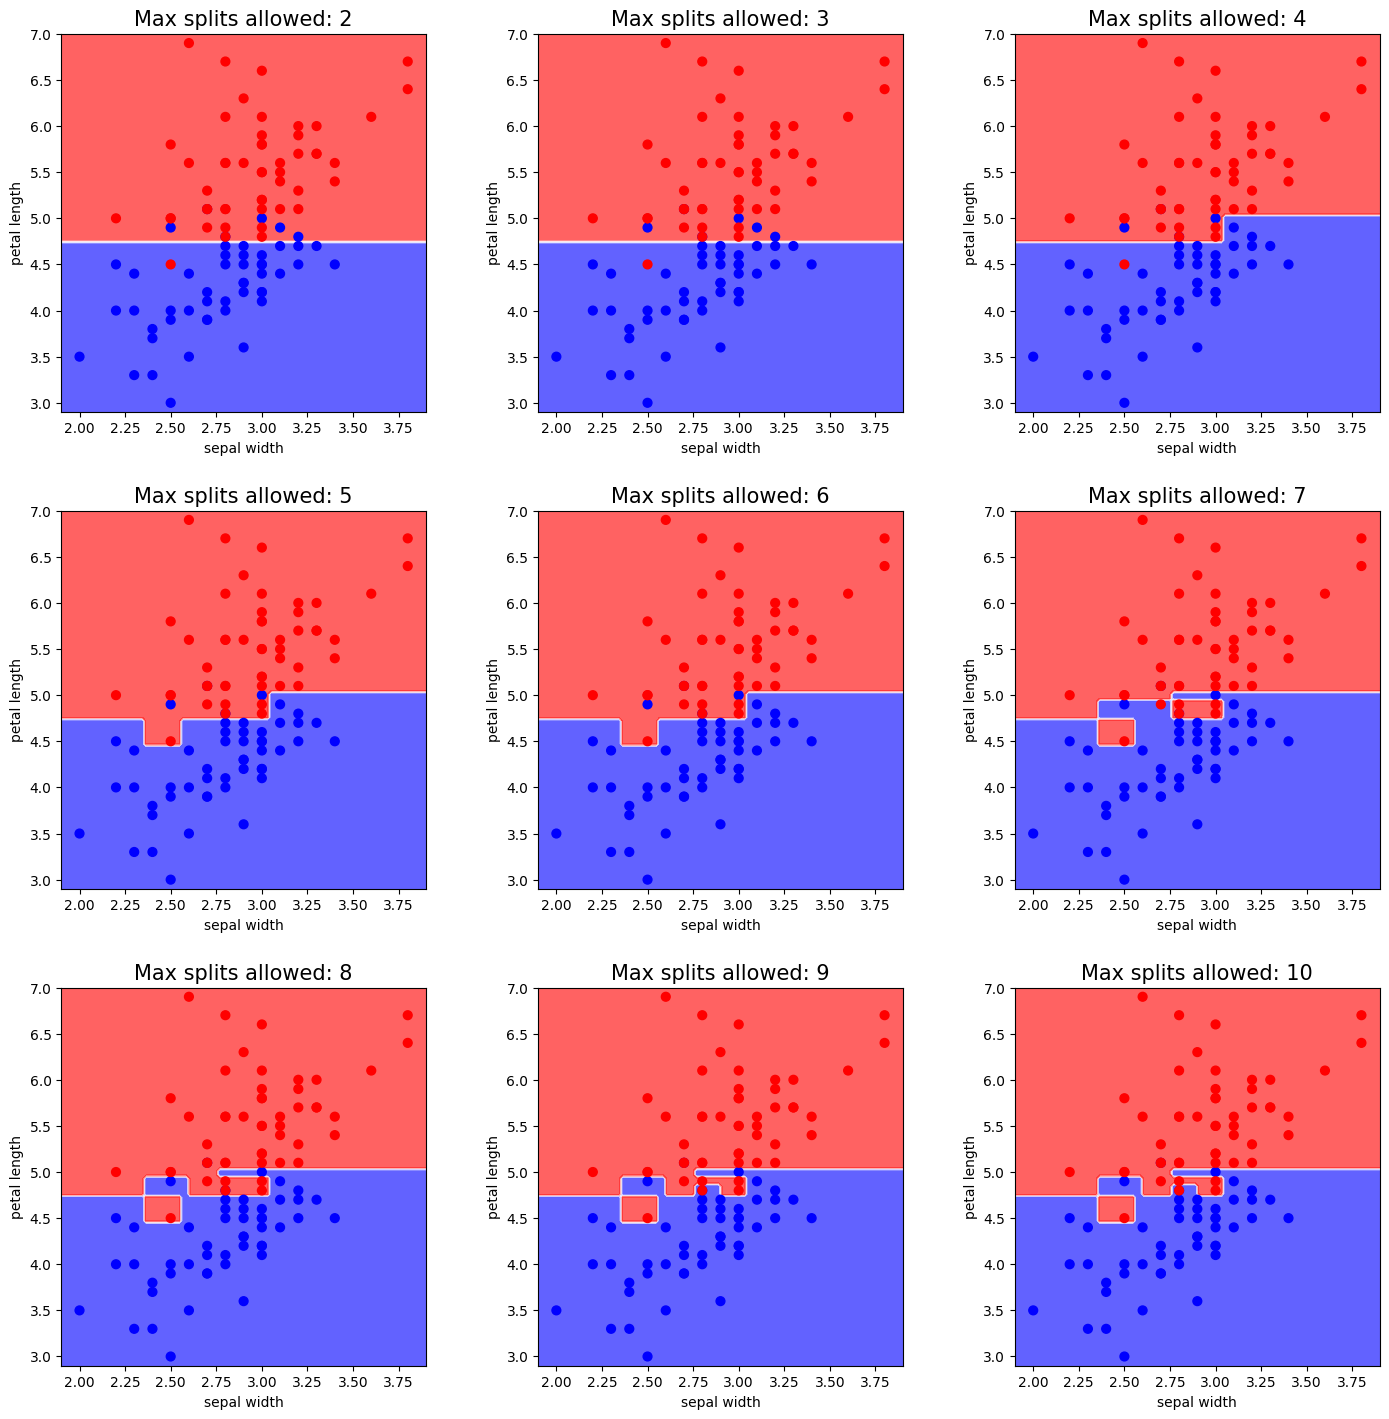

In [8]:
fig, axs = plt.subplots(ncols=3, nrows=3)
fig.set_size_inches(15,15)
fig.tight_layout(pad=5.0)

for max_depth in range(1,10):
  tree_classifier = DecisionTreeClassifier(max_depth = max_depth)
  tree_classifier.fit(X, y)
  
  n_nodes = tree_classifier.tree_.node_count
  children_left = tree_classifier.tree_.children_left
  children_right = tree_classifier.tree_.children_right

  splits_indexes = [i for i in range(n_nodes) if children_left[i] != -1 or children_right[i] != -1]

  r = int((max_depth - 1) / 3)
  c = int((max_depth - 1) % 3)

  plot_decision_boundary(X, y, tree_classifier, axs[r, c], f'Max splits allowed: {max_depth + 1}', 'sepal width', 'petal length') 	


# Part 3: Analyzing the data using ICC plots

In the following code, I'll present how ICC will plot the same data.

In [9]:
#@title Press here to load ICC code

import numpy as np
import graphviz
import matplotlib.colors as mc
import re
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

PRESENT_ALL = 'all'
PRESENT_VISITED = 'visited'
PRESENT_MISCLASSIFIED = 'misclassified'

##################
## Graphvitz utils

replace_words = ['<thead>', '<tbody>', '</thead>', '</tbody>', '\n', '\rn', '<table border="1" class="dataframe">',
                 '</table>']
pattern = '|'.join(replace_words)

def dataframe_to_graphviz_table(df):
    '''
    Translates a html table to graphviz format
    references:
    https://renenyffenegger.ch/notes/tools/Graphviz/attributes/label/HTML-like/index
    https://graphviz.org/Gallery/gradient/table.html
    '''
    html_table = df.to_html()
    return re.sub(pattern, '', html_table).replace('th', 'td').replace('<td>', '<td border="1" bgcolor = "white">')

def to_graphviz_format(node_header, cm):
    cm_table = dataframe_to_graphviz_table(cm)
    return '<<table border = "0">' \
           '<tr><td border = "0" colspan="3"><b>%s</b></td></tr>' \
            '%s' \
           '</table>>' % (node_header, cm_table)

####################
def create_legend (expected_label, predicted_label, expected_label_color, predicted_label_color,
                   present_legends_header):
    elc = color_to_hex(expected_label_color)
    plc = color_to_hex(predicted_label_color)
    if present_legends_header:
        return f'<<table border = "0">' \
               f'<tr><td border = "1" bgcolor= "{elc}"> expected label </td> \
                    <td border = "1" bgcolor= "{plc}"> predicted label </td></tr>' \
               f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                    <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
               f'</table>>'
    else:
        return f'<<table border = "0">' \
               f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                    <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
               f'</table>>'

def create_cm_for_node(tp, fp, tn, fn, true_label, false_label):
    if tp == 0 and fp == 0 and tn == 0 and fn == 0:
        return None
    else:
        return pd.DataFrame({false_label: [tn, fn], true_label: [fp, tp]}, index = [false_label,true_label])

def get_nodes_visits_count_list(n_nodes, node_indicator, samples_ids):
    visits_count = [0] * n_nodes
    for sample_id in samples_ids:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_indexes = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]
        for node_index in node_indexes:
            visits_count[node_index] += 1
    return visits_count

def color_to_hex(color):
    try:
        color = mc.cnames[color]
    except:
        pass
    return color

def merge_color(first_color, first_color_quantity, second_color, second_color_quantity):
    if first_color_quantity == 0 and second_color_quantity == 0:
        return 'white'
    else:
        fc = color_to_hex(first_color)
        sc = color_to_hex(second_color)
        fc_rgb = tuple(int(fc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        sc_rgb = tuple(int(sc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        total = first_color_quantity + second_color_quantity
        adjusted_r = round((first_color_quantity * fc_rgb[0] + second_color_quantity * sc_rgb[0]) / total)
        adjusted_g = round((first_color_quantity * fc_rgb[1] + second_color_quantity * sc_rgb[1]) / total)
        adjusted_b = round((first_color_quantity * fc_rgb[2] + second_color_quantity * sc_rgb[2]) / total)
        return '#%02x%02x%02x' % (adjusted_r, adjusted_g, adjusted_b)

def plot_misclassification_in_tree(clf, X, y, expected_label, predicted_label,
                                   expected_label_color, predicted_label_color,
                                   present_legends_header = True,
                                   show_cm = True, present = PRESENT_ALL,
                                   highlight_false_negative = True,
                                   present_misclassification = True,
                                   im_size = 1000):
    y = np.array(y)  # Will be easier if y is guaranteed to be of type np array
    v = graphviz.Digraph()

    v.node(str(-1), create_legend(expected_label, predicted_label, expected_label_color, predicted_label_color, present_legends_header),
           {'shape': 'component', 'style': 'filled', 'fillcolor': 'white'})

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    classification = clf.predict(X)
    node_indicator = clf.decision_path(X)

    # Step 1: check how the true data traverse along the classifier
    expected_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == expected_label]
    predicted_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == predicted_label]

    expected_label_labeled_visit_count = get_nodes_visits_count_list(n_nodes, node_indicator, expected_label_labeled_samples_ids)
    predicted_label_labeled_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, predicted_label_labeled_samples_ids)

    # Step 2: inspect how the classifier would classify the samples - and create a confusion marix for it.
    true_positive_samples_ids = [i for i in range(len(X)) if
                                 y[i] == expected_label and classification[i] == expected_label]
    false_positive_samples_ids = [i for i in range(len(X)) if
                                  y[i] == predicted_label and classification[i] == expected_label]
    true_negative_samples_ids = [i for i in range(len(X)) if
                                 y[i] == predicted_label and classification[i] == predicted_label]
    false_negative_samples_ids = [i for i in range(len(X)) if
                                  y[i] == expected_label and classification[i] == predicted_label]

    tp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_positive_samples_ids)
    fp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_positive_samples_ids)
    tn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_negative_samples_ids)
    fn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_negative_samples_ids)

    if PRESENT_ALL == present:
        nodes_ids_to_plot = range(n_nodes)
    elif PRESENT_VISITED == present:
        total_visits_count = [sum(x) for x in zip(tp_visits_count, fp_visits_count, tn_visits_count, fn_visits_count)]
        nodes_ids_to_plot = [i for i in range(len(total_visits_count)) if total_visits_count[i] > 0]
    elif PRESENT_MISCLASSIFIED == present:
        nodes_ids_to_plot = [i for i in range(len(fn_visits_count)) if fn_visits_count[i] > 0]
    else:
        raise Exception('Uknown present value: %s' % present)

    for i in nodes_ids_to_plot:
        node_id = str(i)

        if children_left[i] == children_right[i]: # this is a leaf
            label = str(clf.classes_[np.argmax(clf.tree_.value[i])])
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label
            peripheries = '2' if highlight_false_negative and fn_visits_count[i] > 0 else '1'
            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

        else: # this is a split node
            node_feature = X.columns[feature[i]]
            node_tresshold = threshold[i]

            label = str(node_feature)
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label

            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            peripheries = '2' if highlight_false_negative and fn_visits_count[i] > 0 else '1'
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

            if children_left[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_left[i]), node_feature + "<=" + str(round(node_tresshold, 5)))
            if children_right[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_right[i]), node_feature + ">" + str(round(node_tresshold, 5)))
    if present_misclassification:
        v.node(str(n_nodes), f'Total misclassification: {len(false_negative_samples_ids)}/{len(X)}',  {'shape': 'underline'}) # TODO replace with existing conut
    
    # v.render(directory='doctest-output', view=True, format='jpeg')
    output_path = v.render(format = 'jpg')
    im = Image.open(output_path) 
      
    # resize the image for better presentation 
    width, height = int(im.width / im.height * im_size), im_size
    im_resized = im.resize((width, height))
    return im_resized

def visualize(X, y, label1, label2, label1_color, label2_color, show_cm = True, max_depth = None, im_size = 1000):
    clf = DecisionTreeClassifier(random_state=42) if max_depth is None else  DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X, y)
    return plot_misclassification_in_tree(clf = clf, X = X, y = y, expected_label = label1, predicted_label = label2,
                                   expected_label_color = label1_color, predicted_label_color = label2_color,
                                   present_legends_header = False,
                                   show_cm = show_cm, present = PRESENT_ALL,
                                   highlight_false_negative = False,
                                   present_misclassification = False,
                                   im_size = im_size)

By spliting the plane by only 3 splits (illustrated by a tree of depth 2) one can get better insights about the overlapping area of the two classes:

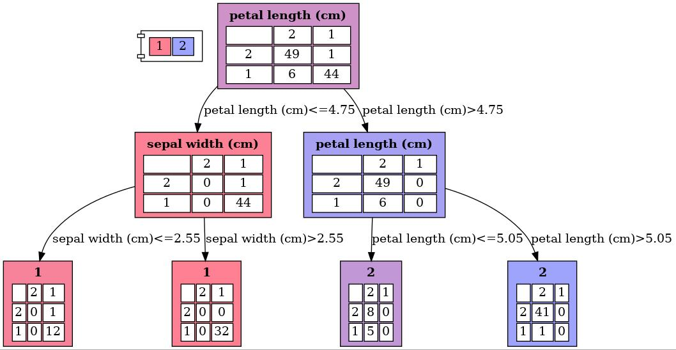

In [10]:
visualize(X, y, 1, 2, '#ff8093', '#9ca5ff', show_cm = True, max_depth = 2, im_size = 350)

As reflected from the above tree, there is almsot a clear separation between class 1 and class 2 based on petal length, with one noticable exception:

In the range of 4.75-5.05, there are eight samples from class 2 and five samples from class 1. This area is highlighted with a gradient color, which is a combination of the colors representing the two classes. The confusion matrix in the node displays the logical classification of this area, and due to the majority of samples being from class 2, this area is classified as class 2, resulting in 5 "misclassified" samples from class 1.

In order to add more splits to gain more information, one can allow a deeper tree by tweaking the max_depth parameter:

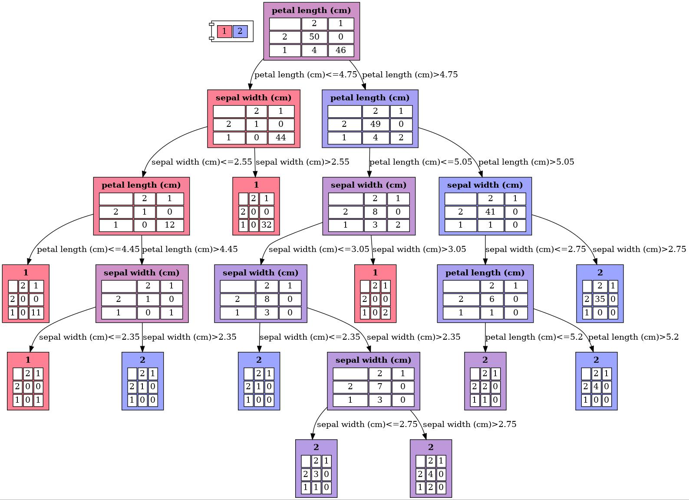

In [11]:
visualize(X, y, 1, 2, '#ff8093', '#9ca5ff', show_cm = True, max_depth = 5, im_size = 500)

To present only the spread of the data and not concrete numbers - set `show_cm` to `False`.

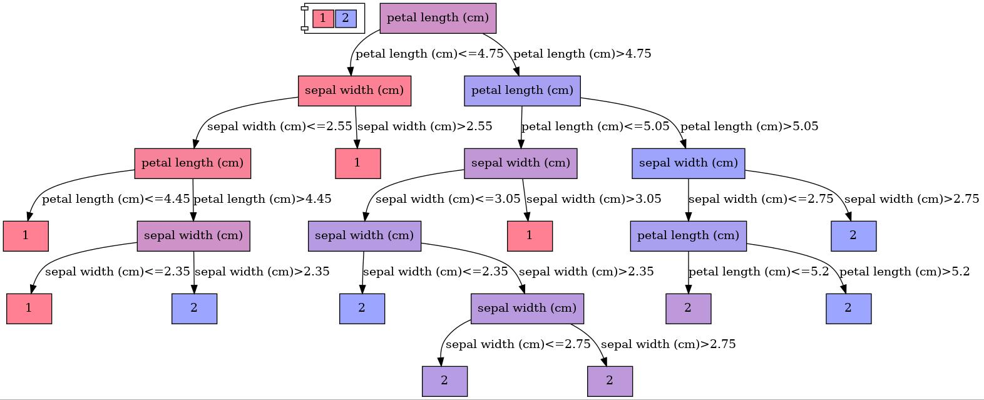

In [12]:
visualize(X, y, 1, 2, '#ff8093', '#9ca5ff', show_cm = False, max_depth = 5, im_size = 400)

Last, the height and the colors of the tree can be further manipulated to fit the researcher choise and need. Here, for example, I'll change the colors in the tree as follows:

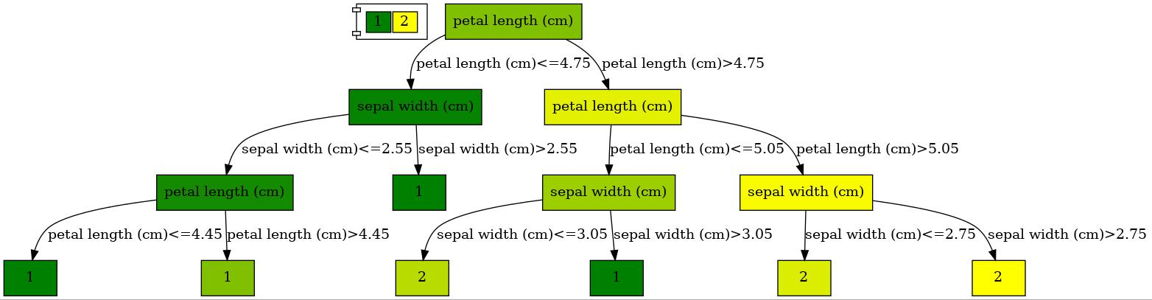

In [13]:
visualize(X, y, 1, 2, 'green', 'yellow', show_cm = False, max_depth = 3, im_size = 300)